In [1]:
import numpy as np
from scipy.special import gamma as gamma_function
from scipy.optimize import minimize
from scipy.stats import gamma
import matplotlib.pyplot as plt
import pydtmc as mc
from scipy.linalg import expm
import pandas as pd
df = pd.read_csv('ACTSC 966/autoclaims.csv')
data = df[["PAID"]].sort_values(by="PAID").reset_index(drop=True).to_numpy()[int(0.2*len(df)):-int(0.05*len(df))]
data /= 1000

In [17]:
%%time

m = 10
beta = np.random.random(m)
pi = np.random.dirichlet(beta)
v_i0 = np.random.uniform(size=m)
v_ij = np.random.uniform(size=(m,m))
xi = np.random.uniform(size=m)

t = [np.random.gamma(shape = v_i0[i],scale = 1/xi[i]) for i in range(m)]
T = [[np.random.gamma(shape = v_ij[i][j],scale = 1/xi[i]) for i in range(m)] for j in range(m)]
T_ = np.zeros((m+1,m+1))
t.append(0)

for i in range(m+1):
    for j in range(m+1):
        if j != m:
            if i != j:
                T_[i][j] = np.random.gamma(shape = v_ij[i-1][j-1],scale = 1/xi[i-1])
T_ = T_.T
T_[m] = t
T_ = T_.T
T_[m] = np.zeros(m+1)
for i in range(m+1):
    T_[i][i] = -sum(T_[i][:-1])
T = T_
MHN = 1
for _ in range(MHN):
    g = np.random.Generator(np.random.PCG64())
    n = data.shape[0]
    dat = data[g.choice(n, 100, replace=False)]
    dt = 0.5*min(dat)[0]
    for x in dat:
        pi = np.random.dirichlet(beta)
        t = [np.random.gamma(shape = v_i0[i],scale = 1/xi[i]) for i in range(m)]
        T = [[np.random.gamma(shape = v_ij[i][j],scale = 1/xi[i]) for i in range(m)] for j in range(m)]
        T_ = np.zeros((m+1,m+1))
        t.append(0)
        for i in range(m+1):
            for j in range(m+1):
                if j != m:
                    if i != j:
                        T_[i][j] = np.random.gamma(shape = v_ij[i-1][j-1],scale = 1/xi[i-1])
        T_ = T_.T
        T_[m] = t
        T_ = T_.T
        T_[m] = np.zeros(m+1)
        for i in range(m+1):
            T_[i][i] = -sum(T_[i][:-1])
        T = T_
        P = expm(np.array(T)*dt)
        P = P / P.sum(axis=1, keepdims=True)
        ch = mc.MarkovChain(p=P)
        done = False
        while not done:
            X = ch.simulate(int(x[0]/dt),np.random.choice(a=[v for v in range(m)],p=pi))
            if X[-1] != str(m+1):
                done = True
        
        done = False
        while not done:
            Y = ch.simulate(int(x[0]/dt),np.random.choice(a=[v for v in range(m)],p=pi))
            if Y[-1] != str(m+1):
                done = True
        
        if np.random.uniform() < min(1, t[int(Y[-1])-1]/t[int(X[-1])-1]):
            J = [int(y) for y in Y]
        else:
            J = [int(x) for x in X]
        
        Bi = [int(J[0]-1 == i) for i in range(m)]
        Zi = np.zeros(m)
        for v in J:
            Zi[v-1] += 1
        Zi *= dt
        
        Nij = np.zeros((m,m))
        for x in range(len(J[:-1])):
            if J[x + 1] != J[x]:
                Nij[J[x]-1][J[x+1]-1] += 1
        Ni0 = np.zeros(m)
        Ni0[J[-2]-1] = 1
        
        Nij, Zi, Bi
        beta += Bi
        v_i0 += Ni0
        v_ij += Nij
        xi += Zi
        
    #if _ % int(MHN/4) == 0:
        #print(beta,'\n', v_i0,'\n', v_ij,'\n', xi)
beta_star = beta
v_i0_star = v_i0
v_ij_star = v_ij
xi_star = xi

CPU times: user 4.71 s, sys: 2.26 s, total: 6.97 s
Wall time: 644 ms


In [28]:
d=100
PDF = np.zeros(d)
K = 10
mn = min(data)
mx = max(data)
X = np.linspace(mn,mx,d)


for k in range(K):        
    pi = np.random.dirichlet(beta)
    t = [np.random.gamma(shape = v_i0[i],scale = 1/xi[i]) for i in range(m)]
    #T = [[np.random.gamma(shape = v_ij[i][j],scale = 1/xi[i]) for i in range(m)] for j in range(m)]
    T_ = np.zeros((m+1,m+1))
    t.append(0)
    for i in range(m+1):
        for j in range(m+1):
            if j != m:
                if i != j:
                    T_[i][j] = np.random.gamma(shape = v_ij[i-1][j-1],scale = 1/xi[i-1])
    T_ = T_.T
    T_[m] = t
    T_ = T_.T
    T_[m] = np.zeros(m+1)
    for i in range(m+1):
        T_[i][i] = -sum(T_[i])
    #print(T_)
    PDF += np.array([pi@expm(np.array(T_.T[:-1].T[:-1])*x)@t[:-1] for x in X])/K

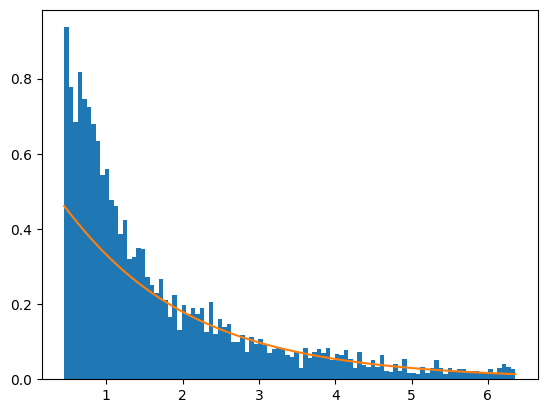

In [29]:
plt.hist(data, bins = 100, density=True)
plt.plot(X, PDF)
#plt.plot(X,e(X))
plt.show()

In [14]:
th = np.mean(data)
def e(x):
    return np.exp(-x/th)/th